# Importing Python libraries and functions

In [1]:
import time
start_time = time.time()
import os
import numpy as np
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import adam
from keras import models
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time 
import progressbar
from tqdm.notebook import tqdm_notebook
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


# Data Preprocessing

In [2]:
# extracting dataframe of cartoon dataset
df = pd.read_csv('../Dataset_original_AMLS_19-20/cartoon_set/labels.csv', sep = '\t')
df = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[1]])
df['face_shape'] = df['face_shape'].apply(str)
df

,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png
...,...,...
9995,2,9995.png
9996,3,9996.png
9997,2,9997.png
9998,2,9998.png


In [3]:
img = ('../Dataset_original_AMLS_19-20/cartoon_set/img')
# splitting training and testing dataset
training, testing = np.split(df.sample(frac=1), [int(0.9*len(df)),]) #splitting at n-array
print(training, testing)

     face_shape file_name
7908          0  7908.png
8086          1  8086.png
4492          2  4492.png
4805          1  4805.png
2789          3  2789.png
...         ...       ...
4236          4  4236.png
5002          3  5002.png
2887          1  2887.png
7941          2  7941.png
647           1   647.png

[9000 rows x 2 columns]      face_shape file_name
3239          2  3239.png
2851          3  2851.png
766           0   766.png
6760          3  6760.png
452           3   452.png
...         ...       ...
6531          0  6531.png
1194          1  1194.png
5862          1  5862.png
5647          3  5647.png
759           1   759.png

[1000 rows x 2 columns]


In [4]:
# set up data generator and further split training dataset for validation set
data_generator = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.2,
    horizontal_flip=True,
    vertical_flip=True   
)

# Get batches of training dataset from the dataframe
print("Training Dataset Preparation: ")
train_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (32,32),
        batch_size = 128, subset = 'training') 
   
# Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparation: ")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (32,32),
        batch_size = 128, subset = 'validation')

Training Dataset Preparation: 
Found 7200 validated image filenames belonging to 5 classes.

Validation Dataset Preparation: 
Found 1800 validated image filenames belonging to 5 classes.


# Implementing CNN

In [19]:
# starting point 
my_model= models.Sequential()

# my_model.add(Dropout(0.2, input_shape=(64,64,3))) 
# Add first convolutional block
my_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(32,32,3) )) #height, width, depth
my_model.add(MaxPooling2D((2, 2), padding='same'))
# second block
# Convolution: filters, kernel_size that specifies the height and width of the 2D convolution window, p padding layers so dimensions of input = output
my_model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
my_model.add(MaxPooling2D((2, 2), padding='same'))
# third block
my_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
my_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))

# make predictions
my_model.add(Flatten())
my_model.add(Dense(5, activation='softmax'))
# Show a summary of the model. Displaying the number of trainable parameters
my_model.summary()
# compile model 
my_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)        

In [20]:
# batch_size = 32
history = my_model.fit_generator(
                                train_generator,
                                epochs=13,
                                steps_per_epoch=train_generator.samples // train_generator.batch_size, 
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // validation_generator.batch_size
                                )

Epoch 1/13
56/56 [==============================] - 73s 1s/step - loss: 1.6064 - accuracy: 0.2285 - val_loss: 1.5864 - val_accuracy: 0.2946
Epoch 2/13
56/56 [==============================] - 60s 1s/step - loss: 1.4028 - accuracy: 0.3811 - val_loss: 1.2053 - val_accuracy: 0.4916
Epoch 3/13
56/56 [==============================] - 51s 904ms/step - loss: 1.0410 - accuracy: 0.5460 - val_loss: 0.9418 - val_accuracy: 0.7111
Epoch 4/13
56/56 [==============================] - 91s 2s/step - loss: 0.6985 - accuracy: 0.7377 - val_loss: 0.4661 - val_accuracy: 0.8463
Epoch 5/13
56/56 [==============================] - 100s 2s/step - loss: 0.4447 - accuracy: 0.8484 - val_loss: 0.4262 - val_accuracy: 0.8882
Epoch 6/13
56/56 [==============================] - 99s 2s/step - loss: 0.3039 - accuracy: 0.9028 - val_loss: 0.2758 - val_accuracy: 0.8995
Epoch 7/13
56/56 [==============================] - 94s 2s/step - loss: 0.2341 - accuracy: 0.9252 - val_loss: 0.2255 - val_accuracy: 0.9121
Epoch 8/13
56/56

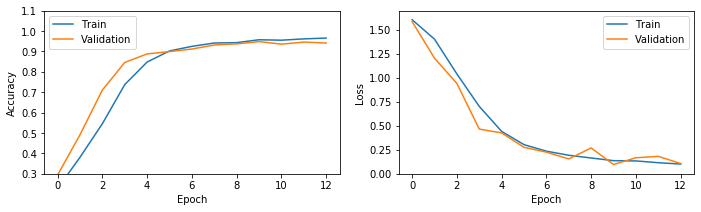

In [21]:
plt.figure(figsize=(18, 3))

# plotting accuracy curve
plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.3,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plotting loss curve
plt.subplot(132)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,1.7])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.savefig("Custom_Keras_ODSC.png", dpi=300)

In [22]:
# saving model
from keras.models import load_model

modelFile = 'my_CNN.h5'

my_model.save(modelFile)

In [23]:
os.getcwd()

'C:\\Users\\User\\Desktop\\4th_year_AMLS\\AMLS_19-20_ChinYangTan_16053203\\Project_AMLS_19-20_16053203\\B1'

# Evaluation of model

In [24]:
# extracting new test dataset
df2 = pd.read_csv('../Dataset_test_AMLS_19-20/cartoon_set_test/labels.csv', sep = '\t')
df2 = df2.drop(columns = [df2.columns[0]]).drop(columns = [df2.columns[1]])
df2['face_shape'] = df2['face_shape'].apply(str)
df2

,face_shape,file_name
0,1,0.png
1,4,1.png
2,2,2.png
3,2,3.png
4,3,4.png
...,...,...
2495,4,2495.png
2496,4,2496.png
2497,4,2497.png
2498,4,2498.png


In [25]:
# image path for new test images
img = ('../Dataset_test_AMLS_19-20/cartoon_set_test/img')

In [26]:
# initial test dataset from splitting
# saved_model = load_model(modelFile)
# test_generator = data_generator.flow_from_dataframe(
#         dataframe = testing, directory = img,
#         x_col = "file_name", y_col = "face_shape",
#         batch_size=1,
#         class_mode='categorical', target_size=(64, 64),
#         shuffle=False)
# test_steps = test_generator.samples
# print(test_steps)

# testing model on new dataset
saved_model = load_model(modelFile)
test_generator = data_generator.flow_from_dataframe(
        dataframe = df2, directory = img,
        x_col = "file_name", y_col = "face_shape",
        batch_size=1,
        class_mode='categorical', target_size=(32, 32),
        shuffle=False)
test_steps = test_generator.samples
print(test_steps)

Found 2500 validated image filenames belonging to 5 classes.
2500


In [27]:
# printing training loss and accuracy
tr_sc = saved_model.evaluate_generator(train_generator, steps = validation_generator.samples // 32, verbose=1)

print('Train loss: '+ str(tr_sc[0]))
print('Train Accuracy: '+ str(tr_sc[1]))

56/56 [==============================] - 31s 551ms/step
Train loss: 0.0731717050075531
Train Accuracy: 0.9677734375


In [28]:
# printing validation loss and accuracy
val_sc = saved_model.evaluate_generator(validation_generator, steps = validation_generator.samples // 32, verbose=1)

print('Validation loss: '+ str(val_sc[0]))
print('Validation Accuracy: '+ str(val_sc[1]))

56/56 [==============================] - 27s 491ms/step
Validation loss: 0.14240598678588867
Validation Accuracy: 0.9440364241600037


In [29]:
test_generator.reset()
pred=saved_model.predict_generator(test_generator, verbose=1, steps=test_steps)
# determine the maximum activation value for each sample
predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)
# label each predicted value to correct face shape
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

2500/2500 [==============================] - 12s 5ms/step


In [30]:
import sklearn.metrics as metrics

[[425  10   1  53  11]
 [ 11 475   0  10   4]
 [  0   0 494   4   2]
 [  6   5   0 482   7]
 [  3   8   1  18 470]]

Confusion Matrix


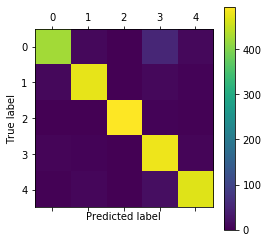

[[0.17   0.004  0.0004 0.0212 0.0044]
 [0.0044 0.19   0.     0.004  0.0016]
 [0.     0.     0.1976 0.0016 0.0008]
 [0.0024 0.002  0.     0.1928 0.0028]
 [0.0012 0.0032 0.0004 0.0072 0.188 ]]

Confusion Matrix (normalised)


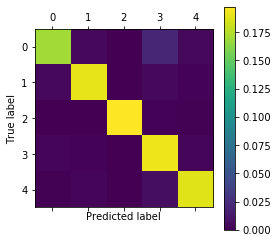

Classification report

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       500
           1       0.95      0.95      0.95       500
           2       1.00      0.99      0.99       500
           3       0.85      0.96      0.90       500
           4       0.95      0.94      0.95       500

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500

Accuracy achieved: 0.9384 ♡♡♡


In [31]:
# displaying confusion matrix
cm = confusion_matrix(test_generator.classes, predicted_class_indices)

print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')
plt.show()


cm2 = confusion_matrix(test_generator.classes, predicted_class_indices, normalize='all')

print(cm2)
plt.matshow(cm2)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix (normalised)')
plt.show()

print('Classification report\n')
print(classification_report(test_generator.classes, predicted_class_indices))
print('Accuracy achieved:', accuracy_score(test_generator.classes, predicted_class_indices), '\u2661''\u2661''\u2661')

In [32]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 4375.229494094849 seconds ---
